<a href="https://colab.research.google.com/github/mohamednihal/Admission-prediction-deeplearning/blob/main/Admission_predictions_Deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score


# load admissions data
admissions_data = pd.read_csv("admissions_data.csv")
print(admissions_data.head())




   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  


In [5]:
admissions_data.describe()
print(admissions_data.shape)

(500, 9)


In [6]:
# mark predicted values
labels = admissions_data.iloc[:,-1]
print(labels.describe())

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit , dtype: float64


In [8]:
# mark features
features = admissions_data.iloc[:, 1:8]
features.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000


In [9]:
#split our training and test set
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, random_state = 42)

# standardizing our data by scaling it
sc = StandardScaler()
features_train_scale = sc.fit_transform(features_train)
features_test_scale = sc.transform(features_test)

In [11]:

features_train_scale = pd.DataFrame(features_train_scale, columns = features_train.columns)
features_test_scale = pd.DataFrame(features_test_scale, columns = features_test.columns)

(features_train_scale.describe())
(features_test_scale.describe())

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,-0.095242,-0.076851,0.034747,-0.029572,0.040541,-0.037003,0.042924
std,1.109474,0.981014,0.972496,0.995919,1.019201,1.024542,0.998343
min,-2.435722,-2.343076,-1.827711,-2.400715,-2.687277,-2.282722,-1.116024
25%,-1.069045,-0.705630,-0.959027,-0.888507,-0.515447,-0.768672,-1.116024
50%,-0.066815,-0.214396,-0.090343,0.119633,0.027510,-0.069879,0.896038
75%,0.753191,0.604327,0.778341,0.623702,0.570467,0.778654,0.896038
max,2.119868,2.078028,1.647025,1.631841,1.656382,2.026498,0.896038


In [12]:
# function to design the model
def design_model(feature_data):
	model = Sequential()
	num_features = feature_data.shape[1]
	input = tf.keras.Input(shape=(num_features))
	model.add(input)
	# this model has two hidden layers and two dropout layers
	# relu activation function is used at both hidden layers
	hidden_layer = layers.Dense(16, activation='relu')
	model.add(hidden_layer)
	model.add(layers.Dropout(0.1))
	hidden_layer_2 = layers.Dense(8, activation='relu')
	model.add(hidden_layer_2)
	model.add(layers.Dropout(0.2))
	model.add(layers.Dense(1))

	# using an adam optimizer with a learning rate of 0.005
	# using mean-squared error as our loss function and mean average error as our metric
	opt = keras.optimizers.Adam(learning_rate=0.005)
	model.compile(loss='mse', metrics=['mae'], optimizer=opt)
	return model

In [14]:
# apply the model to the scaled training data
model = design_model(features_train_scale)
(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [15]:
# apply early stopping for efficiency
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit the model with 100 epochs and a batch size of 8
# validation split at 0.25
history = model.fit(features_train_scale, labels_train.to_numpy(), epochs=100, batch_size=8, verbose=1, validation_split=0.25, callbacks=[es])

# evaluate the model
val_mse, val_mae = model.evaluate(features_test_scale, labels_test.to_numpy(), verbose = 0)


Epoch 1/100
36/36 [==============================] - 1s 5ms/step - loss: 0.3275 - mae: 0.4543 - val_loss: 0.0512 - val_mae: 0.1886
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 0.1074 - mae: 0.2630 - val_loss: 0.0292 - val_mae: 0.1386
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0702 - mae: 0.2069 - val_loss: 0.0228 - val_mae: 0.1264
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0513 - mae: 0.1736 - val_loss: 0.0134 - val_mae: 0.0886
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0391 - mae: 0.1501 - val_loss: 0.0160 - val_mae: 0.1110
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0311 - mae: 0.1395 - val_loss: 0.0100 - val_mae: 0.0810
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0265 - mae: 0.1264 - val_loss: 0.0093 - val_mae: 0.0785
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0186 - m

In [16]:
# view the MAE performance
print("MAE: ", val_mae)

MAE:  0.05256049335002899


In [17]:
# evauate r-squared score
y_pred = model.predict(features_test_scale)

print(r2_score(labels_test,y_pred))

0.7297649682354207


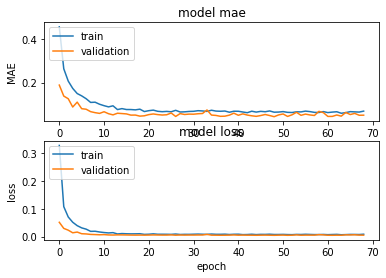

In [18]:
# plot MAE and val_MAE over each epoch
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Plot loss and val_loss over each epoch
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()